# Q5

5. (Unsupervised labeling) This exercise concerns the classdemo.py file shared with
you. We saw that EM algorithm learnt the hidden parameters fairly well. This
question asks you to classify every point to each coin. Record the error rate of
this “classifier”.

In [108]:
# type: ignore

import numpy as np

# bias of coina
ta = 0.1

# bias of coinb
tb = 0.8

# the number of trials
d = 10

# total samples
n = 30

# hidden A =0 B=1
z = np.zeros(n)

# number of heads
x = np.zeros(n)

# For each trial, randomly choose whether to pick A or B
for i in range(n):
    if np.random.uniform() < 0.5:  # picking A
        x[i] = np.random.binomial(d, ta)
        # np.random.binomial(n, p) returns a random number from binomial distribution = number of successes in n trials
    else:
        x[i] = np.random.binomial(d, tb)  # picking B
        if np.random.uniform() < 0.5:
            z[i] = 1

# print(x)
# print(z)

# forget zs
currAEst = 0.51  # current estimate of A
currBEst = 0.534  # current estimate of B

repeatcount = 1000  # instead of checking for convergence
gammaiA = np.zeros(n)  # creating a vector of zeros
gammaiB = np.zeros(n)


for i in range(repeatcount):
    # EStep starts
    for j in range(n):
        gammaiA[j] = 0.5 * np.power(currAEst, x[j]) * \
            np.power(1-currAEst, d-x[j])
        # mathematically,
        # gammaiA[j] = P(z[j] = 0 | x[j], theta) = P(x[j] | z[j] = 0, theta) * P(z[j] = 0 | theta) / P(x[j] | theta)
        gammaiA[j] /= (0.5*np.power(currAEst, x[j]) * np.power(1-currAEst, d-x[j]) +
                       0.5 * np.power(currBEst, x[j]) * np.power(1-currBEst, d-x[j]))
        gammaiB[j] = 1 - gammaiA[j]

    numA = denA = numB = denB = 0
    # Estep ends

    # MStep starts
    for k in range(n):
        numA += gammaiA[k]*x[k]  # sum of gammaiA * x
        numB += gammaiB[k]*x[k]  # sum of gammaiB * x
        denA += gammaiA[k]*d    # Finding the denominator of the Mstep for A
        denB += gammaiB[k]*d    # Finding the denominator of the Mstep for B
    currAEst = numA/denA  # Finding the new estimate of A
    currBEst = numB/denB    # Finding the new estimate of B
    # Msteps ends

print(currAEst, currBEst)
# currAEst gives me he probability of coin being in cluster A
# currBEst gives me he probability of coin being in cluster B


0.08026573233285653 0.7831421143422221


<!-- This creates a boolean array of the same size as gammaiA and gammaiB, where each element is True if the corresponding element in gammaiA is less than the corresponding element in gammaiB, and False otherwise. Then, we cast this boolean array to an integer array using the astype method, which maps True to 1 and False to 0. -->

In [109]:
y_pred = (gammaiA < gammaiB).astype(int)
y_pred


array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1])

<!-- Here's a more concise way to write the same code using NumPy:

makefile
Copy code
Perr = np.mean(y_pred != z)


The expression y_pred != z creates a boolean array of the same size as y_pred and z, where each element is True if the corresponding element in y_pred is not equal to the corresponding element in z, and False otherwise. We can then use the np.mean function to compute the proportion of elements in this array that are True, which gives us the error rate (Perr) as a fraction between 0 and 1.

Note that we don't need to initialize cntOfWrongPred to 0 and use np.float128 data type, since NumPy will automatically promote the data type to handle decimal calculations. -->

In [110]:
y_pred = (gammaiA < gammaiB).astype(int)
y_pred

0.26666666666666666

# Q6

(Auto labeling with EM) In practice, availability of labelled datasets is difficult.
One approach is to cluster the dataset suitably and then retrospectively assign
label to each cluster. Using the approach described in Figure 9.10 of Bishop

cluster the MNIST dataset into 10 clusters using mixture of bernoulli distribu-
tions and then examine the average cluster. Thereafter, each cluster is labelled

based on the average cluster. Record, how many points were misclassified based
on this approach.

In [111]:

import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
from scipy.io import loadmat
from scipy.stats import multivariate_normal as mvn

In [112]:

# load digits
from sklearn.datasets import load_digits
digits = load_digits()
df = pd.DataFrame(digits.data)
df['target'] = digits.target
df


0    1     2     3     4     5    6    7    8    9  ...   55   56  \
0     0.0  0.0   5.0  13.0   9.0   1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1     0.0  0.0   0.0  12.0  13.0   5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2     0.0  0.0   0.0   4.0  15.0  12.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3     0.0  0.0   7.0  15.0  13.0   1.0  0.0  0.0  0.0  8.0  ...  0.0  0.0   
4     0.0  0.0   0.0   1.0  11.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...   ...  ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...  ...   
1792  0.0  0.0   4.0  10.0  13.0   6.0  0.0  0.0  0.0  1.0  ...  0.0  0.0   
1793  0.0  0.0   6.0  16.0  13.0  11.0  1.0  0.0  0.0  0.0  ...  0.0  0.0   
1794  0.0  0.0   1.0  11.0  15.0   1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1795  0.0  0.0   2.0  10.0   7.0   0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1796  0.0  0.0  10.0  14.0   8.0   1.0  0.0  0.0  0.0  2.0  ...  0.0  0.0   

       57   58    59    60    61   62   63  target  
0     0.0  6.0  13.0  10.0   0.0  0.0  0.0       0  
1     0.0  0.0  11.0  16.0  10.0  0.0  0.0       1  
2     0.0  0.0   3.0  11.0  16.0  9.0  0.0       2  
3     0.0  7.0  13.0  13.0   9.0  0.0  0.0       3  
4     0.0  0.0   2.0  16.0   4.0  0.0  0.0       4  
...   ...  ...   ...   ...   ...  ...  ...     ...  
1792  0.0  2.0  14.0  15.0   9.0  0.0  0.0       9  
1793  0.0  6.0  16.0  14.0   6.0  0.0  0.0       0  
1794  0.0  2.0   9.0  13.0   6.0  0.0  0.0       8  
1795  0.0  5.0  12.0  16.0  12.0  0.0  0.0       9  
1796  1.0  8.0  12.0  14.0  12.0  1.0  0.0       8  

[1797 rows x 65 columns]

In [113]:
# Binarize the data except the target column
df[df.columns[:-1]] = (df[df.columns[:-1]] > 0.5).astype(int)
df


0  1  2  3  4  5  6  7  8  9  ...  55  56  57  58  59  60  61  62  63  \
0     0  0  1  1  1  1  0  0  0  0  ...   0   0   0   1   1   1   0   0   0   
1     0  0  0  1  1  1  0  0  0  0  ...   0   0   0   0   1   1   1   0   0   
2     0  0  0  1  1  1  0  0  0  0  ...   0   0   0   0   1   1   1   1   0   
3     0  0  1  1  1  1  0  0  0  1  ...   0   0   0   1   1   1   1   0   0   
4     0  0  0  1  1  0  0  0  0  0  ...   0   0   0   0   1   1   1   0   0   
...  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
1792  0  0  1  1  1  1  0  0  0  1  ...   0   0   0   1   1   1   1   0   0   
1793  0  0  1  1  1  1  1  0  0  0  ...   0   0   0   1   1   1   1   0   0   
1794  0  0  1  1  1  1  0  0  0  0  ...   0   0   0   1   1   1   1   0   0   
1795  0  0  1  1  1  0  0  0  0  0  ...   0   0   0   1   1   1   1   0   0   
1796  0  0  1  1  1  1  0  0  0  1  ...   0   0   1   1   1   1   1   1   0   

      target  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
1792       9  
1793       0  
1794       8  
1795       9  
1796       8  

[1797 rows x 65 columns]

In [114]:
# All features
x = df.drop('target', axis=1)
x


0   1   2   3   4   5   6   7   8   9   ...  54  55  56  57  58  59  60  \
0      0   0   1   1   1   1   0   0   0   0  ...   0   0   0   0   1   1   1   
1      0   0   0   1   1   1   0   0   0   0  ...   0   0   0   0   0   1   1   
2      0   0   0   1   1   1   0   0   0   0  ...   1   0   0   0   0   1   1   
3      0   0   1   1   1   1   0   0   0   1  ...   1   0   0   0   1   1   1   
4      0   0   0   1   1   0   0   0   0   0  ...   0   0   0   0   0   1   1   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
1792   0   0   1   1   1   1   0   0   0   1  ...   1   0   0   0   1   1   1   
1793   0   0   1   1   1   1   1   0   0   0  ...   1   0   0   0   1   1   1   
1794   0   0   1   1   1   1   0   0   0   0  ...   0   0   0   0   1   1   1   
1795   0   0   1   1   1   0   0   0   0   0  ...   1   0   0   0   1   1   1   
1796   0   0   1   1   1   1   0   0   0   1  ...   1   0   0   1   1   1   1   

      61  62  63  
0      0   0   0  
1      1   0   0  
2      1   1   0  
3      1   0   0  
4      1   0   0  
...   ..  ..  ..  
1792   1   0   0  
1793   1   0   0  
1794   1   0   0  
1795   1   0   0  
1796   1   1   0  

[1797 rows x 64 columns]

In [115]:
y = df['target']
y


0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int64

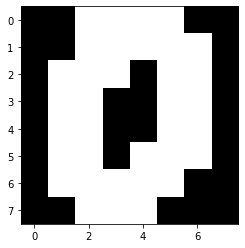

In [116]:
# Generate first image
plt.imshow(x.iloc[0].values.reshape(8,8), cmap='gray')
plt.show()

In [117]:
y.value_counts()


3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64

In [118]:
def Estep(X, mu, pi):
    N = X.shape[0]
    K = mu.shape[0]
    gamma = np.zeros((N, K), dtype=np.float128)

    for k in range(K):
        gamma[:, k] = np.prod((mu[k]**X)*((1-mu[k])**(1-X)), axis=1)

    gamma *= pi
    gamma /= np.sum(gamma, axis=1, keepdims=True)

    return gamma


In [119]:
def Mstep(X, gamma):
    N = X.shape[0]
    K = gamma.shape[1]
    D = X.shape[1]
    pi = np.sum(gamma, axis=0, dtype=np.float128) / N
    mu = (np.sum(gamma[:, :, None] * X[:, None, :], axis=0) / Nk[:, None])
    return mu, pi


In [120]:
def logLikelihood(X, gamma, mu, pi):
    N = X.shape[0]
    K = gamma.shape[1]
    D = X.shape[1]
    ll = 0
    for k in range(K):
        ll += np.sum(gamma[:, k] * np.log(pi[k] * np.prod((mu[k]**X)*((1-mu[k])**(1-X)), axis=1)))
    return ll
    

In [121]:
def EM(df, K, delta=0.001):
    X = df.to_numpy()
    N, D = X.shape

    # Initialize mu and pi
    mu = np.random.uniform(low=0.25, high=0.75, size=(K, D))
    mu = mu / np.sum(mu, axis=1, keepdims=True)
    pi = np.random.uniform(.25, .75, K)
    pi = pi / np.sum(pi)

    cur_llh = np.float(1e9)
    prev_llh = 0.0
    iter = 0
    while (abs(cur_llh-prev_llh) > delta):
        # E-step
        gamma = Estep(X, mu, pi)

        # M-step
        Nk = np.sum(gamma, axis=0)
        mu = (gamma.T @ X) / Nk[:, None]
        pi = Nk / N

        iter += 1
        prev_llh = cur_llh
        cur_llh = logLikelihood(X, gamma, mu, pi)

    label = np.argmax(gamma, axis=1)
    print(iter)
    return mu, pi, label, gamma


In [122]:
K = 10
mu, pi, label, gamma = EM(x, K)


<ipython-input-120-aab5b4bb82f3>:7: RuntimeWarning: divide by zero encountered in log
  ll += np.sum(gamma[:, k] * np.log(pi[k] * np.prod((mu[k]**X)*((1-mu[k])**(1-X)), axis=1)))


5


<ipython-input-120-aab5b4bb82f3>:7: RuntimeWarning: invalid value encountered in multiply
  ll += np.sum(gamma[:, k] * np.log(pi[k] * np.prod((mu[k]**X)*((1-mu[k])**(1-X)), axis=1)))


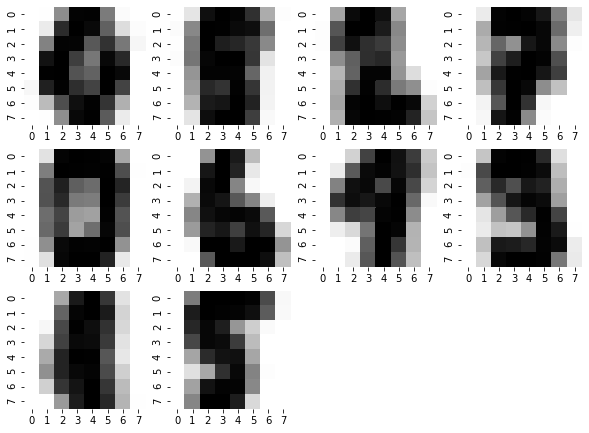

In [123]:
plt.figure(figsize=(10, 10))
for i in range(0, K):
    # increase the size of the figure
    plt.subplot(4,4, i+1)
    sns.heatmap(mu[i].reshape(8, 8), cmap='binary', cbar=False)
plt.show()


In [124]:
arr = [1,2,9,4,3,5,7,6,0,8]

In [125]:
y_pred = np.zeros(gamma.shape[0])
for i in range(0, gamma.shape[0]):
    y_pred[i] = arr[int(label[i])]

y_pred


array([3., 0., 0., ..., 2., 6., 9.])

In [126]:
acc = sklearn.metrics.accuracy_score(y, y_pred)
acc


0.03450194769059544

In [127]:
Misclassified_points = (1-acc)*gamma.shape[0]
Misclassified_points


1735.0

In [128]:
confusionMat = sklearn.metrics.confusion_matrix(y, y_pred)
confusionMat


array([[  1,  98,   0,  75,   0,   0,   4,   0,   0,   0],
       [ 73,   0,  14,   1,   9,  18,   0,  49,   7,  11],
       [  9,   0,   0,   4,   0,   2,  29,   0,   0, 133],
       [  3,   0,   2,  20,   3,   0, 146,   2,   3,   4],
       [ 15, 141,   3,   0,   6,   0,   0,  16,   0,   0],
       [  0,   5,  26,  11,   0,   0,  45,   2,  92,   1],
       [ 12,  16,   2,   0,   0,  93,   0,   0,   1,  57],
       [  0,   1,   0,   3, 151,   0,   0,  24,   0,   0],
       [ 27,   0,  67,  16,   3,   0,  32,   9,  11,   9],
       [  1,   0,   3,  15,   7,   0, 127,  25,   2,   0]])

Text(0.5, 1.0, 'Confusion Matrix')

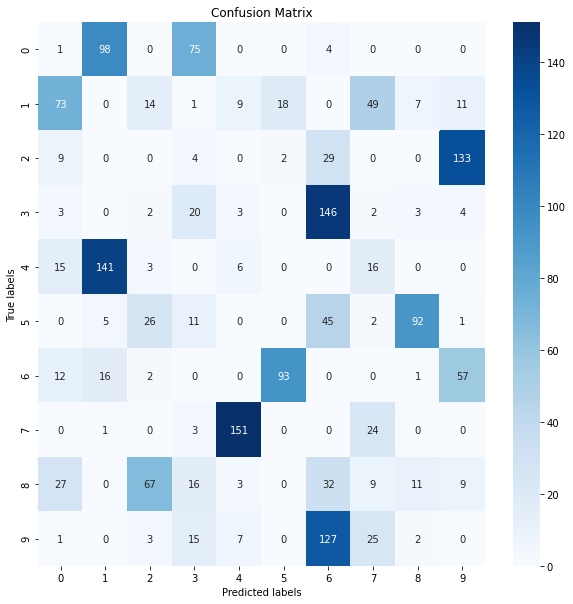

In [129]:

ax = plt.subplots(figsize=(10, 10))

# annot=True to annotate cells, ftm='g' to disable scientific notation
ax = sns.heatmap(confusionMat, annot=True, fmt='g',cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')


# Q7

In [130]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
from scipy.special import erfinv


In [131]:
N = 10000   # number of data points

p1 = 0.05  # probability of class 1
p0 = 0.95  # probability of class 0

dataset = np.array([[]])  # initialize dataset


In [132]:
y = np.random.binomial(1, p1, N)
x = np.where(y == 0, np.random.normal(0, 1, N), np.random.normal(1, 1, N))
dataset = np.column_stack((x, y))


In [133]:
dataset.shape


(10000, 2)

In [134]:
df = pd.DataFrame(dataset, columns=['X', 'Y'])
df.head()


X    Y
0  0.308921  0.0
1  0.193413  0.0
2 -0.320705  0.0
3  1.125659  0.0
4 -0.042598  0.0

In [135]:
def f0(x, mu=0, sigma=1):
    x = float(x - mu) / sigma
    return math.exp(-x*x/2.0) / math.sqrt(2.0*math.pi) / sigma


def f1(x, mu=1, sigma=1):
    x = float(x - mu) / sigma
    return math.exp(-x*x/2.0) / math.sqrt(2.0*math.pi) / sigma


In [136]:
Hb = np.zeros(N)

for i in range(0, N):
    y = df.iloc[i][1]
    x = df.iloc[i][0]
    Q1 = (p1*f1(x))/(p1*f1(x)+p0*f0(x))
    Q0 = (p0*f0(x))/(p1*f1(x)+p0*f0(x))
    if Q1 >= Q0:
        Hb[i] = 1
    else:
        Hb[i] = 0


In [137]:
df['Hb'] = Hb
df.head()


X    Y   Hb
0  0.308921  0.0  0.0
1  0.193413  0.0  0.0
2 -0.320705  0.0  0.0
3  1.125659  0.0  0.0
4 -0.042598  0.0  0.0

In [138]:
import numpy as np

f = np.zeros((2, 2))
idx1 = df.iloc[:, 1] == 1
idx2 = df.iloc[:, 2] == 1
f[0][0] = np.sum(idx1 & idx2)
f[1][0] = np.sum(idx1 & ~idx2)
f[0][1] = np.sum(~idx1 & idx2)
f[1][1] = np.sum(~idx1 & ~idx2)


In [139]:
f


array([[1.000e+00, 1.000e+00],
       [4.800e+02, 9.518e+03]])

In [140]:
TP = f[0][0]
TN = f[1][1]
FP = f[0][1]
FN = f[1][0]


In [141]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("Precision: " + str(precision))
print("Recall: " + str(recall))


Precision: 0.5
Recall: 0.002079002079002079


In [142]:
confusionMat = sklearn.metrics.confusion_matrix(df['Y'], df['Hb'])
confusionMat


array([[9518,    1],
       [ 480,    1]])

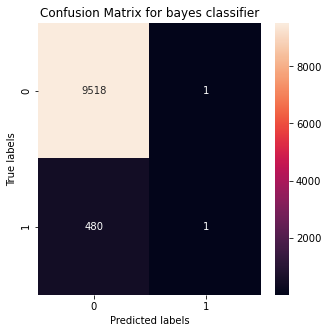

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(confusionMat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for bayes classifier')
plt.show()


In [144]:
cntOfWrongPred = np.sum(y != Hb)
Perr = cntOfWrongPred / N
Perr


0.0002

# For Neyman Pearson classifier

In [145]:
df2 = pd.DataFrame(dataset, columns=['X', 'Y'])
df2.head()


X    Y
0  0.308921  0.0
1  0.193413  0.0
2 -0.320705  0.0
3  1.125659  0.0
4 -0.042598  0.0

# Q2 (d)
 According to neyman pearson classifier, let us say the type 1 error that is Probability of false alarm is upper bounded by some alpha, then the classifier would predict class 1 if f1/f0 > K where K is such that P(f1/f0<=K | X belongs to class 0)=1-alpha.
 Using these calculations, for the class conditional densities given in question, classifier would predict class 1 if X>tau, where  tau = erfinverse(1-2*alpha)*(2^(1/2))


In [146]:
alpha = 0.2
tau = erfinv(1-2*alpha)*(math.sqrt(2))


In [147]:
y_pred = np.zeros(df2.shape[0])
y_pred[df2['X'] > tau] = 1


In [148]:
sklearn.metrics.accuracy_score(y_pred, df2["Y"])


0.7879

In [149]:
confusionMat = sklearn.metrics.confusion_matrix(df2['Y'], y_pred)
confusionMat


array([[7617, 1902],
       [ 219,  262]])

Text(0.5, 1.0, 'Confusion Matrix for neyman pearson classifier')

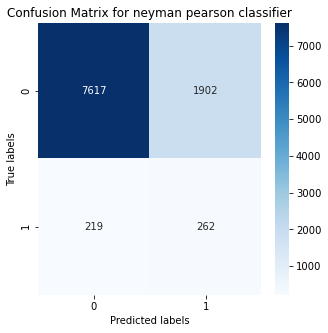

In [150]:

ax = plt.subplots(figsize=(5, 5))

ax = sns.heatmap(confusionMat, annot=True, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for neyman pearson classifier')


## Q2 (e)
#### ROC curve is a plot between Probability of correct detection and Probability of false alarm for different thresholds.
#### H(x)=1 if x>=tau
#### H(x)=0 if x < tau
#### So Pcd=1-P(x <= tau | X belongs to class 1) Pfa=P(x>tau | X belongs to class 0)
#### By elimination tau from these two equations, we would get a relationship between Pcd and Pfa which has been shown in function "calc"


In [151]:
def calc(Pfa):
    Pcd = -(math.erf(erfinv(1-2*Pfa)-1.0/math.sqrt(2))-1.0)/2.0
    return Pcd


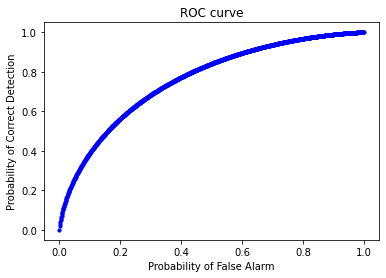

In [152]:
Pfas = np.linspace(0, 1, 1000)
for i in range(0, len(Pfas)):
    plt.scatter(Pfas[i], calc(Pfas[i]), s=10, c=["b"])
plt.title("ROC curve")
plt.ylabel("Probability of Correct Detection")
plt.xlabel("Probability of False Alarm")
plt.show()


## Q2 (f)
#### Considering that cost of P(h(x)!=y|y=0) and P(h(x)!=y|y=1) are equal
#### Therefore for the minimax classifier, integration of f1 over R0 is equal to integration of f0 over R1, by solving this equation, we would get R0 and R1. In this case, by solving this equation, R0 is for x<0.5 and R1 is for x>=0.5

In [153]:
y_pred = np.zeros(df2.shape[0])
for i in range(0, df2.shape[0]):
    if df2.iloc[i]['X'] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0


In [154]:
sklearn.metrics.accuracy_score(y_pred, df2["Y"])


0.6943

Text(0.5, 1.0, 'Confusion Matrix for minimax classifier')

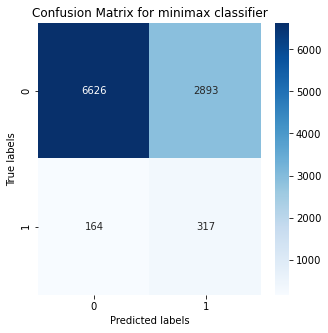

In [155]:
confusionMat = sklearn.metrics.confusion_matrix(df2['Y'], y_pred)
confusionMat
ax = plt.subplots(figsize=(5, 5))

ax = sns.heatmap(confusionMat, annot=True, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix for minimax classifier')
